In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender==1.0.8 
!pip install box2d-py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!rm -r video


In [2]:
import os
import sys
import time
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from colabgymrender.recorder import Recorder


In [3]:
class NN(nn.Module):
    def __init__(self, num_states, num_actions):
        super(NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_states, 6),
            nn.ReLU(),
            nn.Linear(6, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            nn.Linear(3, num_actions),
            # nn.ReLU(),
        )

    def forward(self, x):
        value = self.fc(x)
        return value


class Agent:
    def __init__(self, states, actions):

        # DQN parameter
        self.n_states = states
        self.n_actions = actions

        # Hyper-parameter
        self.batch_size = 128
        self.lr = 0.001
        self.epsilon = 0.9  # 設定初始epsilon
        self.epsilon_decay = 0.8  # 設定epsilon隨著step的decay程度
        self.min_epsilon = 0.1  # 設定最小epsilon值
        self.gamma = 0.90
        self.target_learn_step = 500  # 每多少step要更新target_model
        self.memory_capacity = 100000  # 存experience的容量
        self.count_memory = 0  # 計算現在memory之中存了多少experience
        self.learn_step = 0  # 計算training step看何時要更新target_model

        self.train_model = NN(states, actions)  # 要train的model
        self.target_model = NN(states, actions)  # train_model的目標，不能更新的model，不然訓練的時候會像是一直追逐自己，反而會無法穩定訓練 Q(s, a) = r + γ * max_a' * Q(s', a')

        # 每一筆experience中存：現在state、next state、reward、action
        # memory存所有experience
        self.memory = np.zeros(((self.memory_capacity, states * 2 + 2)))

        self.optimizer = torch.optim.Adam(self.train_model.parameters(),
                                          lr=self.lr)

        # MSE loss
        self.MSE = nn.MSELoss()

    def act(self, state):

        x = torch.unsqueeze(torch.FloatTensor(state), 0)

        # 根據epsilon-greedy policy選擇action
        if np.random.uniform() < self.epsilon:  # 在epsilon的機率之下，agent會隨機動作才有可能學到新的action帶來的新的experience
            action = np.random.randint(0, self.n_actions)
        else:  # 根㯫train_model決定action
            action_value = self.train_model(x)
            action = torch.max(action_value, 1)[1].data.numpy()[0]  # 選擇最大的valu的action

        return action

    def save_experience(self, state, action, reward, next_state):

        tmp_experience = np.hstack((state, [action, reward], next_state))
        # 存進memory，若memory滿了會把舊的覆蓋掉
        # 用circular memory index存放方式
        memory_index = self.count_memory % self.memory_capacity
        self.memory[memory_index, :] = tmp_experience
        self.count_memory += 1

    def DQN_learn(self):

        # experience replay的部分，從memory存著的experience之中隨機抽樣出來learn
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        sample_experience = self.memory[sample_index, :]  # 隨機sample的experience
        sample_state = torch.FloatTensor(sample_experience[:, :self.n_states])  # sample experience的state
        sample_action = torch.LongTensor(sample_experience[:, self.n_states:self.n_states+1].astype(int))  # sample experience的action
        sample_reward = torch.FloatTensor(sample_experience[:, self.n_states+1:self.n_states+2])  # sample experience的reward
        sample_next_state = torch.FloatTensor(sample_experience[:, -self.n_states:])  # sample experience的next state

        q_value = self.train_model(sample_state).gather(1, sample_action)  # 計算sample experience在當下train_model的Q-value
        q_value_next = self.target_model(sample_next_state).detach()  # target_model要freeze住所以用detach()，不會訓練到
        q_value_target = sample_reward + self.gamma * q_value_next.max(1)[0].view(self.batch_size, 1)  # 計算sample experience在當下target_model的Q-value
        loss = self.MSE(q_value, q_value_target)  # 計算train_model跟target_model之間的loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 每target_learn_step更新一次target_model，把train_model的參數直接複製過去
        self.learn_step += 1
        if self.learn_step % self.target_learn_step == 0:
            self.target_model.load_state_dict(self.train_model.state_dict())


Episode 1 結束，moves = 119, total_rewards = -438.0248050785908
Episode 2 結束，moves = 144, total_rewards = -547.1894853306053
Episode 3 結束，moves = 79, total_rewards = -109.58363918968509
Episode 4 結束，moves = 78, total_rewards = -90.79520367357436
Episode 5 結束，moves = 97, total_rewards = -129.66047806199612
Episode 6 結束，moves = 92, total_rewards = -95.89192739643799
Episode 7 結束，moves = 83, total_rewards = -51.61251616617817
Episode 8 結束，moves = 89, total_rewards = -5.561844119268933
Episode 9 結束，moves = 91, total_rewards = 3.1988889694743055
Episode 10 結束，moves = 82, total_rewards = -43.85891721625948
Episode 11 結束，moves = 71, total_rewards = -71.06742423480954
Episode 12 結束，moves = 74, total_rewards = -17.012270441343247
Episode 13 結束，moves = 70, total_rewards = -24.599523054942964
Episode 14 結束，moves = 80, total_rewards = -258.07184672229096
Episode 15 結束，moves = 57, total_rewards = -327.31887041486306
Episode 16 結束，moves = 62, total_rewards = -278.0181703175366
Episode 17 結束，moves = 60,

 99%|█████████▉| 128/129 [00:00<00:00, 274.08it/s]


<Figure size 864x288 with 0 Axes>

Text(0.5, 1.0, 'Total_rewards curve')

Text(0.5, 0, 'Episode')

Text(0, 0.5, 'Total_rewards')

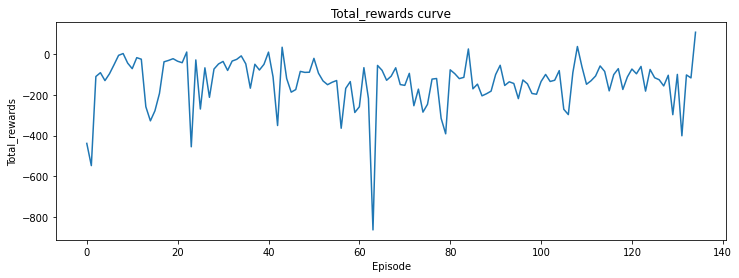

In [4]:
# 創建要互動的環境
env = gym.make('LunarLander-v2')
directory = './video'
env = Recorder(env, directory)

# Hyper-parameter
num_episodes = 1500

s = env.observation_space.shape[0]  # state:(8,)
a = env.action_space.n  # action:4

DQN = Agent(states=s, actions=a)

# 訓練
total_rewards = []
for episode in range(num_episodes):
    moves = 0
    rewards = 0
    state = env.reset()

    DQN.epsilon = 0.9  # 每個episode都將epsilon初始化回0.9

    while True:
        # 開始根據state決定action
        action = DQN.act(state)

        if DQN.epsilon > DQN.min_epsilon:  # 如果epsilon未到設定的min，每一次action之後都decay一次epsilon
            DQN.epsilon = DQN.epsilon * DQN.epsilon_decay

        # 在環境中執行action並得到回饋
        next_state, reward, done, info = env.step(action)
        if reward <= -100:  # 因為墜落到地板的reward是-100,在這裡改設小一點，鼓勵agent降落地面
            reward = -1
        if moves == 1000:
            reward = -150

        # 將此次experience存起準備做replay & learn
        DQN.save_experience(state, action, reward, next_state)

        # 加總reward
        rewards += reward

        # memory_capacity存滿了就learn
        if DQN.count_memory > DQN.batch_size:
            DQN.DQN_learn()

        # 往下一步state走
        state = next_state

        # 如果這次玩完了(done)，印出這次做了幾個moves跟reward然後break這個episode
        if done:
            print('Episode {} 結束，moves = {}, total_rewards = {}'.format(episode+1, moves+1, rewards))
            total_rewards.append(rewards)
            break

        moves += 1
    if rewards >= 100:
        break

env.play()

# 可以稍微畫一下整個total_rewards的curve
plt.figure(figsize=(12, 4))
plt.title('Total_rewards curve')
plt.xlabel('Episode')
plt.ylabel('Total_rewards')
plt.plot(total_rewards)
plt.savefig('./total_rewards_curve.png')  # , bbox_inches='tight', pad_inches=0
plt.show()


# 1. (b) Please choose some hyper-parameters about collecting and using trajectories and analyze how these hyper-parameters affect the training result or training time. 

**Ans**:

在訓練過程之中我曾多次修改一些hyper-parameters，由於未完整記下所有實驗過程，因此以條列式描述我在訓練過程之中對於一些hyper-parameters的調整以及發現：



1.   **epsilon**：在我最初的模型設計階段，一開始我設定epsilon為0.1(並未使用epsilon decay)，使得agent隨機採取動作不太足夠，導致其在環境中表現沒有很好。
後來我找到epsilon decay的相關做法，讓agent可以去嘗試多一點隨機的行為學習更多經驗，能夠表現越來越好。

2.   **gamma**：gamma我總共嘗試過0.9、0.95、0.99，我發現在0.9的時候會較穩定訓練，若gamma設的太高，訓練過程會不太穩定而且可能要花很多Episode才可以收斂到較好的結果。從DQN algorithm中的式子可以解讀為若gamma設的越高的話，會希望模型較為關注下一個state的q-value而非現在，這樣會導致模型訓練不穩定。

3.   **target_learn_step**：此參數表示何時要更新target model的參數，若設的太小(太快更新target model的參數)，則可能會讓模型學習到太多連續action的相關性，因此不能設的太小。

4.   **memory_capacity**：我把memory_capacity的容量設到100,000，讓其盡可能多保存一些經驗以便後續sample出來learn。在一開始我的memory_capacity設100、200，看訓練的結果我覺得可能有些重要的經驗因為memory_capacity不夠而被覆蓋掉，因此把memory_capacity設大一點。

5.   **reward上的調整**：由於墜機的話reward是-100，訓練到最後我的agent會傾向一直停留在空中而不敢貿然降落，拖到1000個moves到遊戲結束。因此我將墜機的reward設為-1，用於鼓勵agent嘗試降落的目的，並且將拖到1000個moves此行為的reward設為-150，告知agent不可以一直拖。

